1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

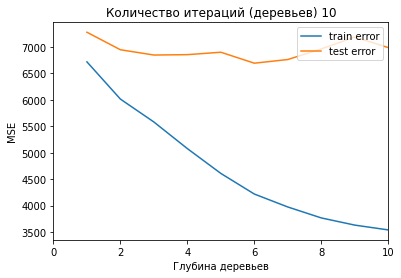

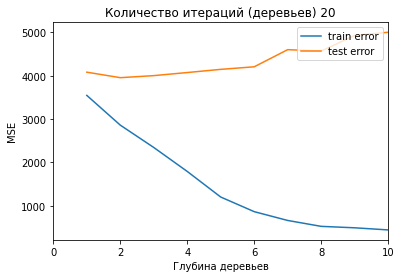

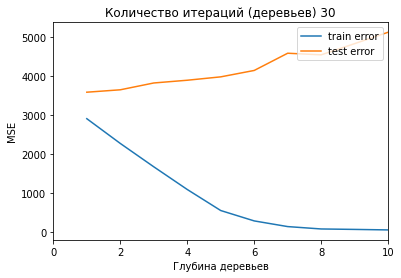

In [10]:
eta = 0.1
max_depth = 10
n_trees = 30

for n in range(10, n_trees+10,10):
    coefs = [1] * n
    A = np.zeros((max_depth, 2))

    for i in range(1, max_depth+1):
        trees, train_errors, test_errors = gb_fit(n, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        A[i-1,0] = mean_squared_error(y_train, train_prediction)
        A[i-1,1] = mean_squared_error(y_test, test_prediction)
    
    plt.title(f'Количество итераций (деревьев) {n}')
    plt.xlabel('Глубина деревьев')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth+1)), A[:,0], label='train error')
    plt.plot(list(range(1, max_depth+1)), A[:,1], label='test error')
    plt.legend(loc='upper right')
    plt.show()


MSE при увеличении количества деревьев уменьшается на трейне и на тесте. При 30 деревьев с глубиной 10 каждого дерева алгоритм выучивает на трейне абсолютно всю выборку. Из графиков видно, что делать глубину деревьев больше 3 смысла нет, хоть на трейне ошибка уменьшается, но на тесте она начинаетс увеличиваться из за переобучения.

 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [11]:
import random
random.seed(42)

def get_bootstrap(X, y):
    n_samples = X.shape[0]  
    n_samples_div2 = n_samples // 2 # Размер подвыборки принять равным 0.5 - берем половину всей выборки
    X_data = np.zeros((n_samples_div2, X.shape[1]))
    y_data = np.zeros(n_samples_div2)
        
    for j in range(n_samples_div2): 
        sample_index = random.randint(0, n_samples-1)
        X_data[j] = X[sample_index]
        y_data[j] = y[sample_index]
        
    return X_data, y_data

In [12]:
def gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    #сохраним полный трейн набор
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        #берем случайную половину от всей выборки трейна для стохастичности
        X_train, y_train = get_bootstrap(X_train_copy, y_train_copy)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [13]:
eta = 0.1
coefs = [1] * n_trees
max_depth = 5
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees2, train_errors2, test_errors2 = gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

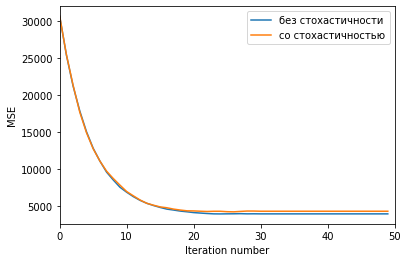

In [14]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label='без стохастичности')
plt.plot(list(range(n_trees)), test_errors2, label='со стохастичностью')
plt.legend(loc='upper right')
plt.show()